In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [54]:
%cd gdrive/MyDrive/comptech

[Errno 2] No such file or directory: 'gdrive/MyDrive/comptech'
/content/gdrive/MyDrive/comptech


In [55]:
import pandas as pd
import numpy as np
import holidays

import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet
from fbprophet.serialize import model_to_json, model_from_json
from fbprophet.diagnostics import cross_validation

import itertools
import datetime
from tqdm import tqdm
import warnings

from sklearn.metrics import mean_absolute_percentage_error

In [56]:
tqdm.pandas()
warnings.simplefilter('ignore')

In [71]:
%pylab inline
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(16, 6)})

Populating the interactive namespace from numpy and matplotlib


### Данные

In [58]:
ORDERS_PATH = 'orders.csv'
DELAYS_PATH = 'partners_delays.csv'
SEED = 2021

In [59]:
orders = pd.read_csv(ORDERS_PATH)
delays = pd.read_csv(DELAYS_PATH)

In [60]:
orders['date'] = pd.to_datetime(orders['date']).astype('datetime64[ns]')
orders['year'] = orders['date'].dt.year
orders['year'].unique()

array([2021])

In [61]:
holidays_dict = holidays.RU(years=(2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays.columns = ['ds', 'holiday']
df_holidays['ds'] = pd.to_datetime(df_holidays['ds'])
df_holidays

,ds,holiday
0,2021-01-01,Новый год
1,2021-01-02,Новый год
2,2021-01-03,Новый год
3,2021-01-04,Новый год
4,2021-01-05,Новый год
5,2021-01-06,Новый год
6,2021-01-07,Православное Рождество
7,2021-01-08,Новый год
8,2021-02-23,День защитника отечества
9,2021-03-08,День женщин


In [62]:
def compute_prev_week_value(row, data):
  prev_week_date = row['date'] - pd.DateOffset(days=7)
  res = data[data['date'] == prev_week_date]['orders_cnt'].mean()
  return res

In [63]:
orders.groupby('delivery_area_id').count()

,date,orders_cnt,year
delivery_area_id,,,
0,2839,2839,2839
1,2958,2958,2958
2,142,142,142
3,2598,2598,2598
4,2844,2844,2844
...,...,...,...
588,1711,1711,1711
589,889,889,889
590,1280,1280,1280


In [64]:
orders_d1 = orders[orders['delivery_area_id'] == 1]
orders_d1['prev_week_value'] = orders_d1.progress_apply(lambda x: compute_prev_week_value(x, orders_d1), axis=1)

100%|██████████| 2958/2958 [00:02<00:00, 1164.21it/s]


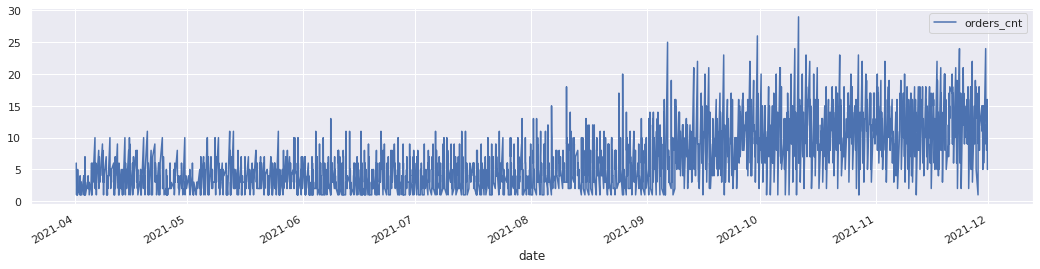

In [65]:
orders_d1['diff'] = orders_d1['orders_cnt'] - orders_d1['prev_week_value']
orders_d1.plot(x='date', y='orders_cnt', figsize=(16, 4))

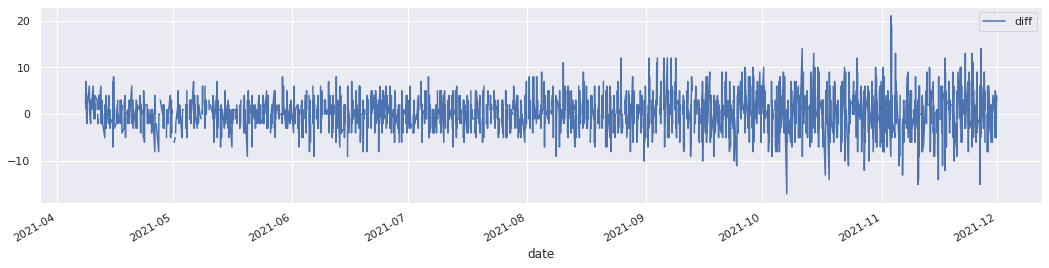

In [66]:
orders_d1.plot(x='date', y='diff', figsize=(16, 4))

In [67]:
def split_date_time(data):
  data['dttm'] = data['date']
  data['date'] = data['dttm'].dt.date
  data['year'] = data['dttm'].dt.year
  data['month'] = data['dttm'].dt.month
  data['dayofweek'] = data['dttm'].dt.dayofweek
  data['time'] = data['dttm'].dt.time
  data['hour'] = data['dttm'].dt.hour
  return data

In [68]:
orders_d1 = split_date_time(orders_d1)
orders_d1.describe()

,delivery_area_id,orders_cnt,year,prev_week_value,diff,month,dayofweek,hour
count,2958.0,2958.000000,2958.0,2739.000000,2739.000000,2958.000000,2958.000000,2958.000000
mean,1.0,6.544963,2021.0,6.569916,0.282950,7.536849,2.994591,15.142326
std,0.0,4.647301,0.0,4.555933,3.796586,2.239278,1.998470,3.623519
min,1.0,1.000000,2021.0,1.000000,-17.000000,4.000000,0.000000,8.000000
25%,1.0,3.000000,2021.0,3.000000,-2.000000,6.000000,1.000000,12.000000
50%,1.0,5.000000,2021.0,5.000000,0.000000,8.000000,3.000000,15.000000
75%,1.0,9.000000,2021.0,9.000000,2.000000,9.000000,5.000000,18.000000
max,1.0,29.000000,2021.0,29.000000,21.000000,11.000000,6.000000,21.000000


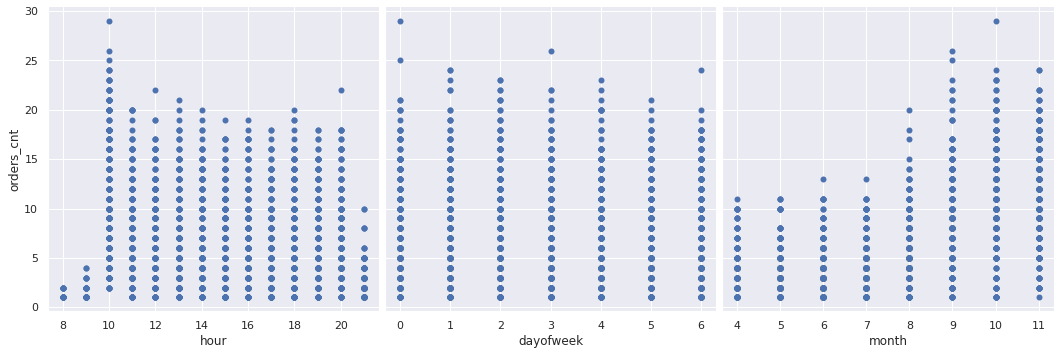

In [75]:
sns.pairplot(
    orders_d1.dropna(),
    x_vars=['hour','dayofweek', 'month'],
    y_vars='orders_cnt',
    height=5,
    plot_kws={'linewidth':0}
)
plt.show()

### Utils

In [76]:
def timeseries_train_test_split(X, y=None, test_size=0.3):
    test_index = int(len(X) * (1 - test_size))
    X_train = X.iloc[:test_index]
    X_test = X.iloc[test_index:]
    if y is not None:
      y_train = y.iloc[:test_index]
      y_test = y.iloc[test_index:]
      return X_train, X_test, y_train, y_test
    return X_train, X_test

In [78]:
orders_d1.columns

Index(['delivery_area_id', 'date', 'orders_cnt', 'year', 'prev_week_value',
       'diff', 'dttm', 'month', 'dayofweek', 'time', 'hour'],
      dtype='object')

In [79]:
orders_d1.columns = ['delivery_area_id', 'ds', 'y', 'year', 'prev_week_value', 'diff', 'dttm', 'month', 'dayofweek', 'time',	'hour']

In [80]:
X_train, X_test = timeseries_train_test_split(orders_d1[['ds', 'y']], test_size=0.3)
X_train.index = X_train['ds']
X_test.index = X_test['ds']
X_train = X_train.drop('ds', axis=1)
X_test = X_test.drop('ds', axis=1)

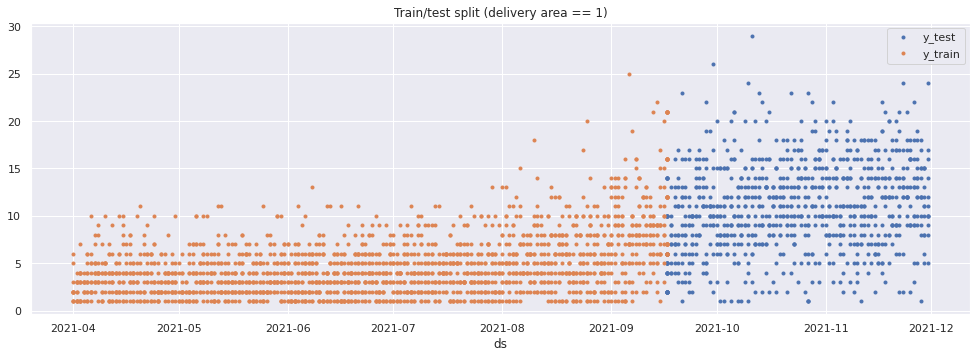

In [81]:
X_test.rename(columns={'y': 'y_test'}).join(X_train.rename(columns={'y': 'y_train'}), how='outer').plot(figsize=(15,5), title='Train/test split (delivery area == 1)', style='.')
plt.show()

In [82]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2.71 s, sys: 73.9 ms, total: 2.78 s
Wall time: 2.79 s


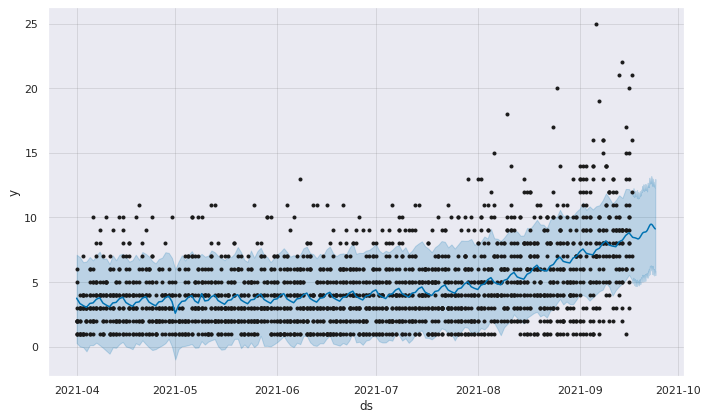

In [84]:
%%time

model = Prophet(holidays=df_holidays, weekly_seasonality=True)
model.fit(X_train)
forecast = model.make_future_dataframe(periods=7*24, freq='H')
forecast = model.predict(forecast)
fig = model.plot(forecast)

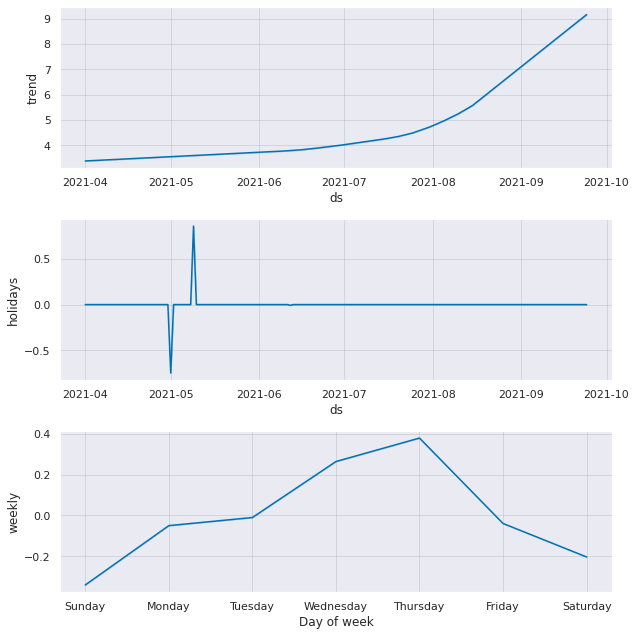

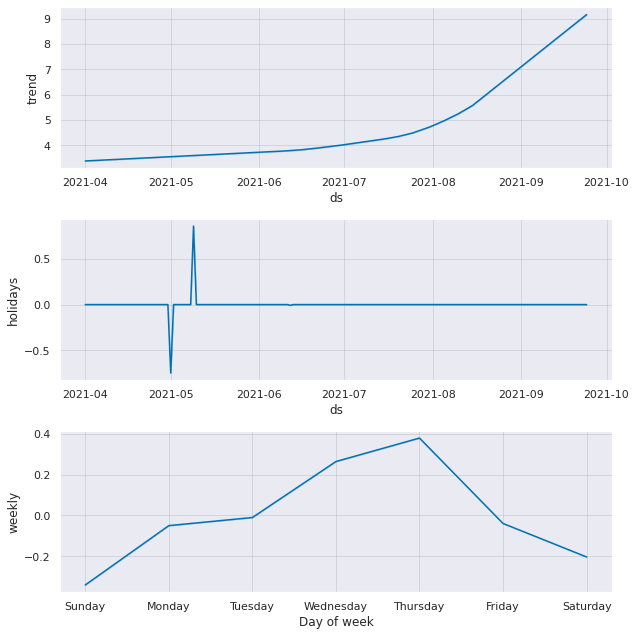

In [85]:
model.plot_components(forecast)

In [86]:
forecast[['yhat', 'yhat_lower',	'yhat_upper']].head()

,yhat,yhat_lower,yhat_upper
0,3.759092,0.293134,7.123033
1,3.345662,0.021059,6.926243
2,3.186979,-0.026079,6.536528
3,3.055173,-0.349562,6.601461
4,3.351889,0.133142,6.941825


In [87]:
test_forecast = model.predict(df=X_test)

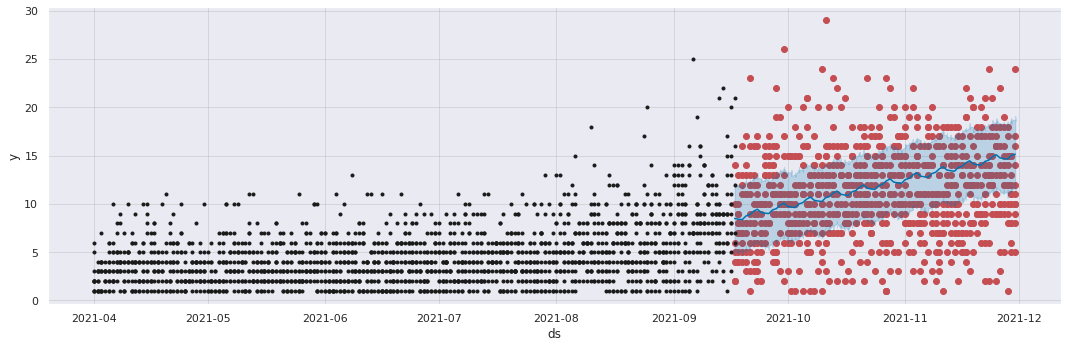

In [90]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_test['ds'], X_test['y'], color='r')
fig = model.plot(test_forecast, ax=ax)

In [96]:
print(mean_absolute_percentage_error(X_test['y'], test_forecast['yhat']))

0.6351120768545894
